# Prédiction de l'étiquette DPE 31



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LassoCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

Fichier pris en entrée : df_dpe_cleaned2.csv 
78 colonnes

In [2]:
#import
df = pd.read_csv("df_dpe_cleaned2.csv", sep=",")
df = df.drop(columns="Unnamed: 0")
df.head()

C:\Users\Ali\AppData\Local\Temp\ipykernel_20700\1804913625.py:2: DtypeWarning: Columns (13,52,53,54,55,57,58,59,60,61,62,65,66,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df_dpe_cleaned2.csv", sep=",")


,N°DPE,Date_établissement_DPE,Modèle_DPE,Version_DPE,Méthode_application_DPE,Etiquette_DPE,Etiquette_GES,Type_bâtiment,Hauteur_sous-plafond,Nombre_appartement,...,Type_énergie_principale_ECS,Période_construction,Apports_internes_saison_chauffe_,Apports_internes_saison_froid,Apports_solaires_saison_chauffe,Apports_solaires_saison_froid,Besoin_refroidissement_dépensier,Conso_chauffage_dépensier_installation_chauffage_n°1,Conso_é_finale_dépensier_installation_ECS,Production_électricité_PV_(kWhep/an)
0,2131N0244530O,2021-09-01,DPE NEUF LOGEMENT : RT2012,1.0,DPE ISSU D'UNE ÉTUDE THERMIQUE RÉGLEMENTAIRE R...,C,C,MAISON,2.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2231N0576591E,2022-03-21,DPE NEUF LOGEMENT : RT2012,2.0,DPE ISSU D'UNE ÉTUDE THERMIQUE RÉGLEMENTAIRE R...,B,A,MAISON,2.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2331N3897138O,2023-11-14,DPE NEUF LOGEMENT : RT2012,2.3,DPE ISSU D'UNE ÉTUDE THERMIQUE RÉGLEMENTAIRE R...,B,B,MAISON,2.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2131N0358152Q,2021-09-21,DPE NEUF LOGEMENT : RT2012,1.0,DPE ISSU D'UNE ÉTUDE THERMIQUE RÉGLEMENTAIRE R...,C,C,APPARTEMENT,2.5,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2231N0905042X,2022-04-27,DPE NEUF LOGEMENT : RT2012,2.0,DPE ISSU D'UNE ÉTUDE THERMIQUE RÉGLEMENTAIRE R...,A,A,APPARTEMENT,2.5,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_dpe = df.copy()
pd.set_option('display.max_columns', 160) # affiche toutes les colonnes
pd.set_option('display.max_rows', 111) # affiche toutes les lignes
df_dpe.shape

(264984, 78)

In [4]:
df_dpe['Etiquette_DPE'].value_counts()

Etiquette_DPE
C    111496
D     68127
E     29310
B     25310
A     15580
F      9958
G      5203
Name: count, dtype: int64

### Description du code

Ce code encode les colonnes catégoriques, filtre les colonnes numériques corrélées à l'étiquette DPE (> 0.1), sélectionne les colonnes catégoriques avec moins de 10 catégories, et génère une liste finale de colonnes pour la modélisation.


In [5]:
# Encoder la colonne cible (Etiquette_DPE) si elle est catégorique
if df_dpe['Etiquette_DPE'].dtype == 'object':
    df_dpe['Etiquette_DPE'] = df_dpe['Etiquette_DPE'].astype('category').cat.codes

# Identifier les colonnes numériques et catégoriques
colonnes_numeriques = df_dpe.select_dtypes(include=['number']).columns
colonnes_categoriques = df_dpe.select_dtypes(include=['object']).columns

# Filtrer les colonnes numériques ayant une corrélation > 0.1 avec Etiquette_DPE
if 'Etiquette_DPE' in df_dpe.columns:
    correlations = df_dpe[colonnes_numeriques].corrwith(df_dpe['Etiquette_DPE']).abs()
    colonnes_corr_eleves = correlations[correlations > 0.1].index.tolist()
else:
    colonnes_corr_eleves = []

# Compter les catégories uniques dans les colonnes catégoriques
resume_categories = {col: df_dpe[col].nunique() for col in colonnes_categoriques}

# Sélectionner les colonnes catégoriques ayant moins de 10 catégories uniques
colonnes_categoriques_sel = [
    col for col, nb_categories in resume_categories.items() if nb_categories < 10
]

# Combiner les colonnes numériques corrélées et les colonnes catégoriques sélectionnées
colonnes_finales = colonnes_corr_eleves + colonnes_categoriques_sel

# Afficher la liste des colonnes retenues
print("Colonnes retenues :", colonnes_finales)
print("Nombre total de colonnes :", len(colonnes_finales))


Colonnes retenues : ['Etiquette_DPE', 'Nombre_appartement', 'Conso_5_usages_é_finale', 'Conso_5_usages/m²_é_finale', 'Conso_5_usages_par_m²_é_primaire', 'Emission_GES_5_usages_par_m²', 'Emission_GES_chauffage_dépensier', 'Coût_chauffage_énergie_n°1', 'Deperditions_baies_vitrées', 'Ubat_W/m²_K', 'Surface_chauffée_installation_chauffage_n°1', 'Surface_habitable_desservie_par_installation_ECS', 'Conso_é_finale_dépensier_installation_ECS', 'Modèle_DPE', 'Etiquette_GES', 'Type_bâtiment', 'Classe_inertie_bâtiment', 'Classe_altitude', 'Zone_climatique_', 'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries', 'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas', 'Type_installation_chauffage_n°1', 'Usage_générateur_n°1_installation_n°1', 'Configuration_installation_ECS', 'Type_installation_ECS', 'Usage_générateur_ECS_n°1']
Nombre total de colonnes : 28


In [6]:
colonnes_selectionnees = [
    'Nombre_appartement', 'Conso_5_usages_é_finale', 'Conso_5_usages/m²_é_finale',
    'Conso_5_usages_par_m²_é_primaire', 'Emission_GES_5_usages_par_m²',
    'Emission_GES_chauffage_dépensier', 'Coût_chauffage_énergie_n°1',
    'Deperditions_baies_vitrées', 'Ubat_W/m²_K',
    'Surface_chauffée_installation_chauffage_n°1',
    'Surface_habitable_desservie_par_installation_ECS',
    'Conso_é_finale_dépensier_installation_ECS', 'Modèle_DPE', 'Type_bâtiment',
    'Classe_inertie_bâtiment', 'Classe_altitude', 'Zone_climatique_',
    'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',
    'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',
    'Type_installation_chauffage_n°1', 'Usage_générateur_n°1_installation_n°1',
    'Configuration_installation_ECS', 'Type_installation_ECS',
    'Usage_générateur_ECS_n°1',
]

## LASSO

### Description du code

Ce code charge les bibliothèques nécessaires, traite les données manquantes, encode les colonnes catégoriques, sélectionne les variables pertinentes, standardise les données, effectue une régression Lasso avec validation croisée, et évalue les performances avec des métriques et une matrice de confusion.

### Analyse du modèle
74% d'accuracy (sans sélectionner l'étiquette_GES) avec A sous-évalué en B, la régression Lasso n'est pas adaptée.


In [7]:
# Gérer les valeurs manquantes dans les colonnes numériques et catégoriques
def GererValeursNan(df : pd.DataFrame) -> pd.DataFrame:
    for col in df.select_dtypes(include=['number']).columns:
        df[col].fillna(0, inplace=True)
    for col in df.select_dtypes(include=['object']).columns:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

C:\Users\Ali\AppData\Local\Temp\ipykernel_20700\3143346367.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)
C:\Users\Ali\AppData\Local\Temp\ipykernel_20700\3143346367.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.01      0.03      3161
           1       0.36      0.79      0.50      5077
           2       0.88      0.76      0.81     22425
           3       0.80      0.88      0.84     13473
           4       0.79      0.74      0.76      5858
           5       0.71      0.62      0.66      1979
           6       0.91      0.71      0.80      1024

    accuracy                           0.74     52997
   macro avg       0.78      0.64      0.63     52997
weighted avg       0.80      0.74      0.73     52997



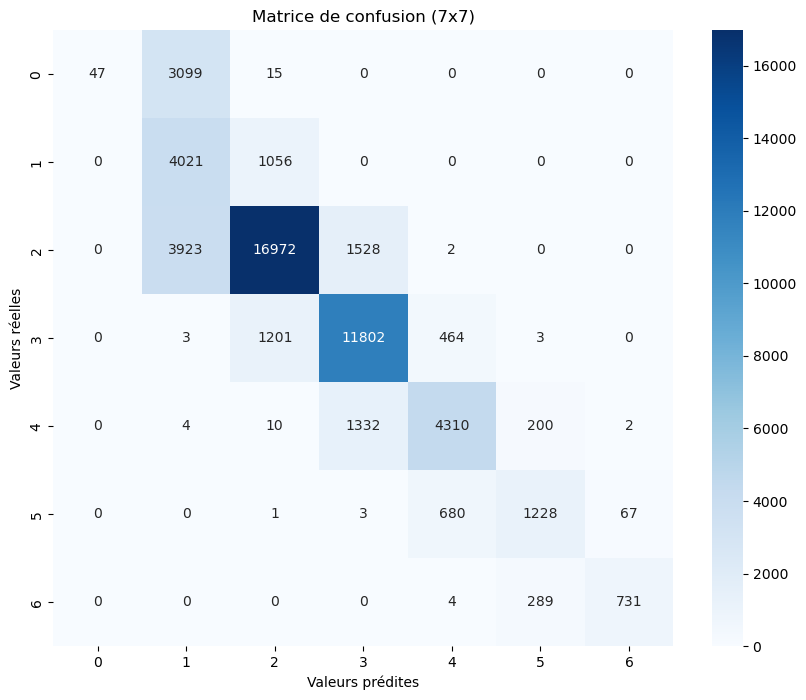

                                              Feature  Coefficient
3                    Conso_5_usages_par_m²_é_primaire     1.004988
4                        Emission_GES_5_usages_par_m²     0.321818
11          Conso_é_finale_dépensier_installation_ECS     0.028577
48    Type_installation_ECS_INSTALLATION INDIVIDUELLE     0.021314
34                Qualité_isolation_murs_INSUFFISANTE     0.020840
6                          Coût_chauffage_énergie_n°1     0.018317
37        Qualité_isolation_plancher_bas_INSUFFISANTE     0.017955
42  Type_installation_chauffage_n°1_INSTALLATION I...     0.015269
7                          Deperditions_baies_vitrées     0.015217
10   Surface_habitable_desservie_par_installation_ECS     0.013226


In [ ]:
df_dpe_nettoyer = GererValeursNan(df_dpe)

if df_dpe_nettoyer['Etiquette_DPE'].dtype == 'object':
    df_dpe_nettoyer['Etiquette_DPE'] = df_dpe_nettoyer['Etiquette_DPE'].astype('category').cat.codes

label_mapping = dict(enumerate(df_dpe_nettoyer['Etiquette_DPE'].astype('category').cat.categories))



X = pd.get_dummies(df_dpe_nettoyer[colonnes_selectionnees], drop_first=True)
y = df_dpe_nettoyer['Etiquette_DPE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardiser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Régression Lasso avec validation croisée
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble de test
y_pred_class = np.clip(np.round(lasso.predict(X_test_scaled)).astype(int), 0, 6)

# Évaluer les performances
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

# Visualiser la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_class, labels=range(7))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.title("Matrice de confusion (7x7)")
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.show()

# Afficher les coefficients du modèle
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso.coef_})
print(coefficients.sort_values(by='Coefficient', ascending=False).head(10))


## Random Forest

### Analyse du modèle

97% d'accuracy (sans l'information étiquette GES) .. A vérifier


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3161
           1       0.96      0.99      0.97      5077
           2       1.00      0.96      0.98     22425
           3       0.95      0.96      0.95     13473
           4       0.92      0.96      0.94      5858
           5       0.91      0.95      0.93      1979
           6       0.93      0.99      0.96      1024

    accuracy                           0.97     52997
   macro avg       0.95      0.97      0.96     52997
weighted avg       0.97      0.97      0.97     52997



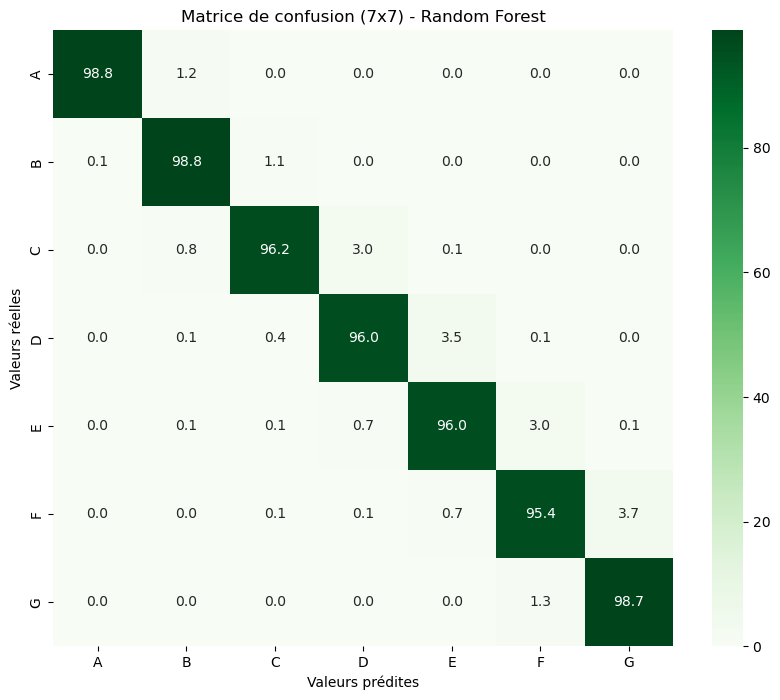

                                  Feature  Importance
3        Conso_5_usages_par_m²_é_primaire    0.295016
4            Emission_GES_5_usages_par_m²    0.187567
2              Conso_5_usages/m²_é_finale    0.181703
5        Emission_GES_chauffage_dépensier    0.034698
6              Coût_chauffage_énergie_n°1    0.034582
1                 Conso_5_usages_é_finale    0.024545
8                             Ubat_W/m²_K    0.023724
7              Deperditions_baies_vitrées    0.021583
34    Qualité_isolation_murs_INSUFFISANTE    0.020980
13  Modèle_DPE_DPE NEUF LOGEMENT : RT2012    0.020310


C:\Users\Ali\AppData\Local\Temp\ipykernel_20700\114342395.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), palette='viridis')


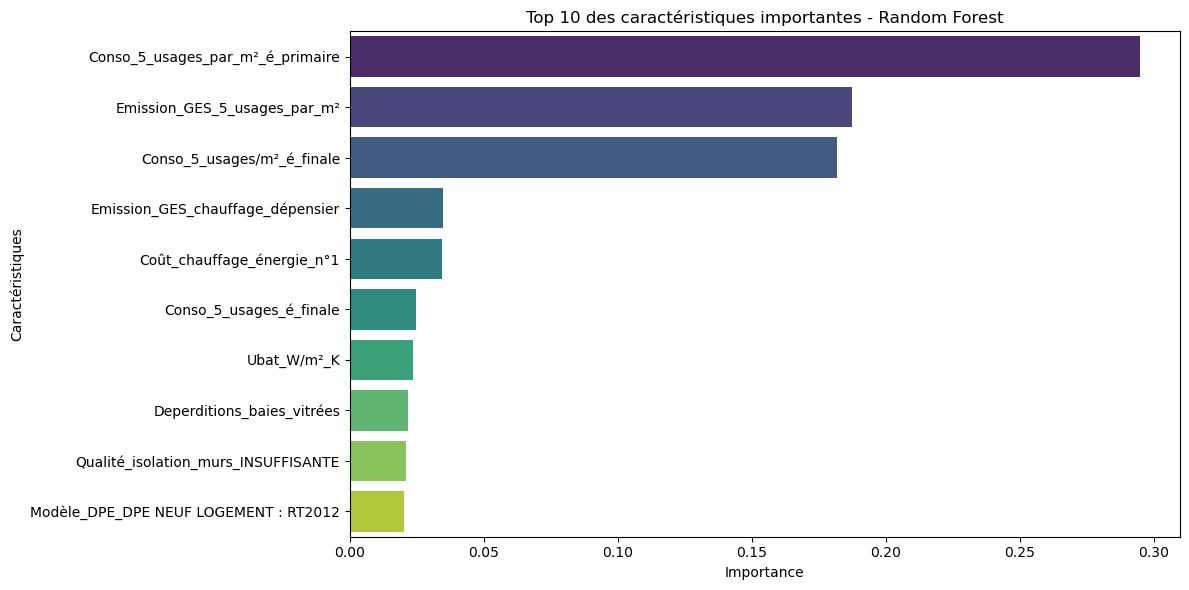

In [9]:
# Modèle Random Forest
scaler = StandardScaler()
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, class_weight='balanced')
rf.fit(scaler.fit_transform(X_train), y_train)

# Évaluation du modèle
y_pred_class = rf.predict(scaler.transform(X_test))
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_class, labels=range(7))
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".1f", cmap="Greens", xticklabels=['A','B', 'C', 'D', 'E', 'F', 'G'], yticklabels=['A','B', 'C', 'D', 'E', 'F', 'G'])
plt.title("Matrice de confusion (7x7) - Random Forest")
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.show()

# Importance des caractéristiques
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)
print(feature_importances.head(10))
# Visualisation de l'importance des caractéristiques
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), palette='viridis')
plt.title("Top 10 des caractéristiques importantes - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Caractéristiques")
plt.tight_layout()
plt.show()

# Modèle de prédiction sans Conso

In [10]:
colonnes_selectionnees = [
    'Nombre_appartement', 'Besoin_chauffage','Surface_habitable_logement',
    'Deperditions_baies_vitrées', 'Ubat_W/m²_K','Période_construction',
    'Surface_chauffée_installation_chauffage_n°1', 'Surface_habitable_desservie_par_installation_ECS'
    , 'Modèle_DPE', 'Type_bâtiment', 'Classe_inertie_bâtiment',
    'Classe_altitude', 'Zone_climatique_', 'Qualité_isolation_enveloppe',
    'Qualité_isolation_menuiseries', 'Qualité_isolation_murs','Coût_chauffage_énergie_n°1',
    'Qualité_isolation_plancher_bas', 'Type_installation_chauffage_n°1',
    'Usage_générateur_n°1_installation_n°1', 'Configuration_installation_ECS',
    'Type_installation_ECS', 'Usage_générateur_ECS_n°1',
]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3161
           1       0.81      0.82      0.82      5077
           2       0.92      0.86      0.89     22425
           3       0.78      0.84      0.81     13473
           4       0.70      0.75      0.73      5858
           5       0.63      0.61      0.62      1979
           6       0.74      0.75      0.75      1024

    accuracy                           0.83     52997
   macro avg       0.78      0.79      0.79     52997
weighted avg       0.83      0.83      0.83     52997



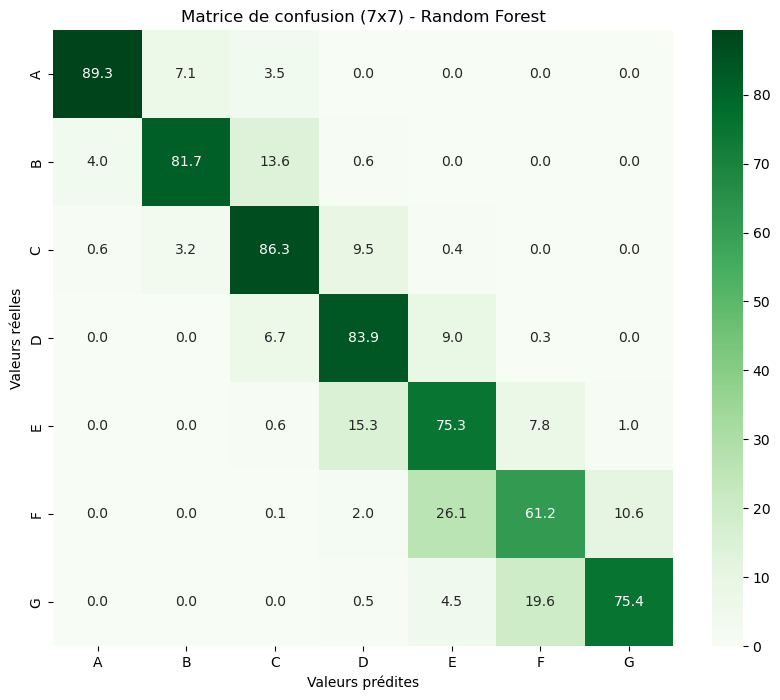

                                             Feature  Importance
7                         Coût_chauffage_énergie_n°1    0.151845
2                         Surface_habitable_logement    0.108013
1                                   Besoin_chauffage    0.103776
4                                        Ubat_W/m²_K    0.093028
6   Surface_habitable_desservie_par_installation_ECS    0.071487
5        Surface_chauffée_installation_chauffage_n°1    0.066934
3                         Deperditions_baies_vitrées    0.065417
0                                 Nombre_appartement    0.043117
39               Qualité_isolation_murs_INSUFFISANTE    0.036383
33          Qualité_isolation_enveloppe_INSUFFISANTE    0.020448


C:\Users\Ali\AppData\Local\Temp\ipykernel_20700\2889947301.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), palette='viridis')


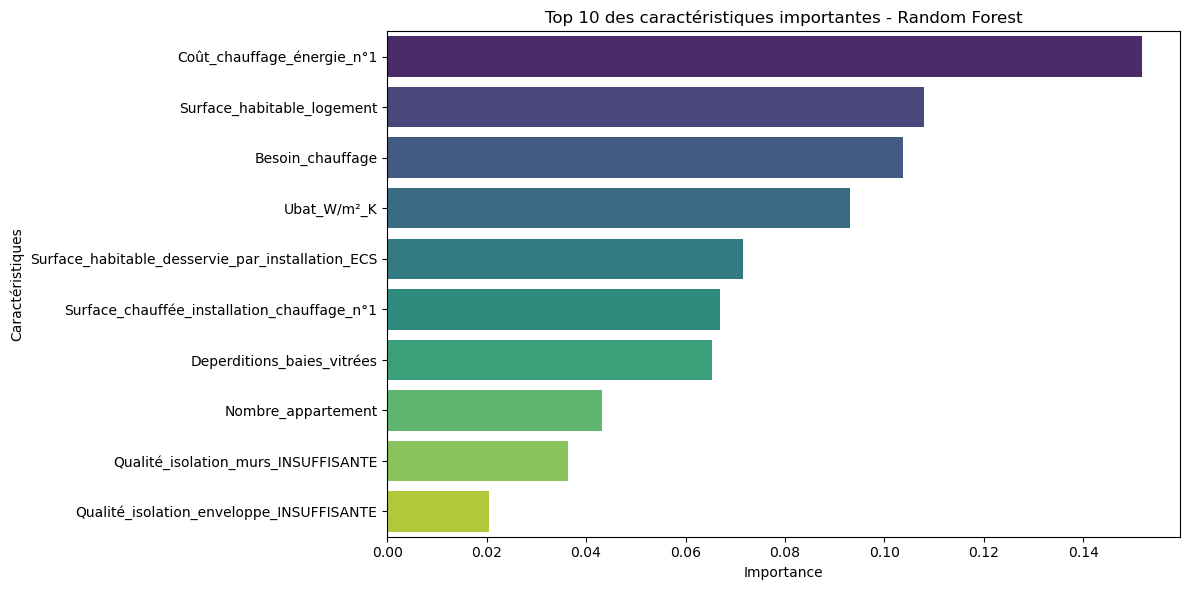

In [11]:
X = pd.get_dummies(df_dpe_nettoyer[colonnes_selectionnees], drop_first=True)
y = df_dpe_nettoyer['Etiquette_DPE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
rf = RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=20, class_weight='balanced')
rf.fit(scaler.fit_transform(X_train), y_train)

y_pred_class = rf.predict(scaler.transform(X_test))
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

conf_matrix = confusion_matrix(y_test, y_pred_class, labels=range(7))
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".1f", cmap="Greens", xticklabels=['A','B', 'C', 'D', 'E', 'F', 'G'], yticklabels=['A','B', 'C', 'D', 'E', 'F', 'G'])
plt.title("Matrice de confusion (7x7) - Random Forest")
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), palette='viridis')
plt.title("Top 10 des caractéristiques importantes - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Caractéristiques")
plt.tight_layout()
plt.show()

# Conclusion

Avec nos données, il serait possible de "prédire" l'étiquette DPE. Toutefois, si le DPE peut être déterminé de manière exacte à partir des colonnes disponibles, la prédiction perd de son utilité, car il s'agirait simplement d'un calcul direct basé sur ces informations. La prédiction sans consommation et émission donne un bon résultat néanmoins avec 83% de précision. 